In [47]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
from tqdm import tqdm

from scipy.spatial import ConvexHull

import lsst.daf.butler as dafButler


from mpl_toolkits.axes_grid1 import make_axes_locatable
from astropy.visualization import ZScaleInterval, SqrtStretch, ImageNormalize, ManualInterval, AsinhStretch, MinMaxInterval, LogStretch


import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

from typing import TYPE_CHECKING, cast

import astropy.units as u
from astropy.coordinates import SkyCoord

plt.set_loglevel('WARNING')

In [48]:
def create_mag_errors(sciFlux, sciFluxErr):
    """Move flux into magnitudes and calculate the error on the magnitude
    
    Parameters
    ----------
    sciFlux : `float`
        Science flux
    sciFluxErr : `float`
        Science flux error

    Returns
    -------
    mag, magerr  : `float`, `float`
        Magnitude and magnitude error
    """
    
    mag = u.nJy.to(u.ABmag, sciFlux)
    upper_mag = u.nJy.to(u.ABmag, sciFlux+sciFluxErr)
    lower_mag = u.nJy.to(u.ABmag, sciFlux-sciFluxErr)
    magErr = -(upper_mag-lower_mag)/2
    
    return mag, magErr

def create_mag(sciFlux):
    """Move flux into magnitudes
    
    Parameters
    ----------
    sciFlux : `float`
        Science flux

    Returns
    -------
    mag  : `float`
        Magnitude
    """
    
    mag = u.nJy.to(u.ABmag, sciFlux)
    
    return mag

In [49]:
# Load collection
repo = '/repo/main'
instrument = "LSSTComCam"
butler= dafButler.Butler(repo, collections='LSSTComCam/runs/DRP/DP1/w_2025_03/DM-48478', instrument=instrument)

# older collections
repo_old = "embargo_new"
butler_02 = dafButler.Butler(repo, collections="LSSTComCam/runs/DRP/20241101_20241211/w_2024_02/DM-48371", instrument=instrument)
butler_50 = dafButler.Butler(repo_old, collections="LSSTComCam/runs/DRP/20241101_20241211/w_2024_50/DM-48128", instrument=instrument)
butler_49 = dafButler.Butler(repo_old, collections="LSSTComCam/runs/DRP/20241101_20241204/w_2024_49/DM-47988", instrument=instrument)
butler_48 = dafButler.Butler(repo_old, collections="LSSTComCam/runs/DRP/20241101_20241127/w_2024_48/DM-47841", instrument=instrument)


INFO:botocore.credentials:Found credentials in shared credentials file: /sdf/home/n/ncaplar/.lsst/aws-credentials.ini


In [50]:
bands = ["u", "g", "r", "i", "z", "y"]
verbose = False

for band in bands:
    datasetRefs_dia = butler.query_datasets("goodSeeingDiff_differenceExp", where=f"band='{band}'")

    if verbose:
        print(f"\nDataset references for band '{band}':")
        for dr in datasetRefs_dia:
            print(dr)

    print(f"Found {len(datasetRefs_dia)} differenceExps for band '{band}'")

Found 1003 differenceExps for band 'u'
Found 4179 differenceExps for band 'g'
Found 5094 differenceExps for band 'r'
Found 2875 differenceExps for band 'i'
Found 2690 differenceExps for band 'z'
Found 583 differenceExps for band 'y'


In [51]:
lc_refs = butler.query_datasets("diaSourceTable_tract")
obj_refs = butler.query_datasets("diaObjectTable_tract")
obj_refs_50 = butler_50.query_datasets("diaObjectTable_tract")
obj_refs_49 = butler_49.query_datasets("diaObjectTable_tract")
obj_refs_48 = butler_48.query_datasets("diaObjectTable_tract")


print(f"Number of tracts in diaSourceTable (current): {len(lc_refs)}")
print(f"Number of tracts in diaObjectTable_tract (current): {len(obj_refs)}")
print(f"Number of tracts in diaObjectTable_tract (weekly 50): {len(obj_refs_50)}")
print(f"Number of tracts in diaObjectTable_tract (weekly 49): {len(obj_refs_49)}")
print(f"Number of tracts in diaObjectTable_tract (weekly 48): {len(obj_refs_48)}")

Number of tracts in diaSourceTable (current): 28
Number of tracts in diaObjectTable_tract (current): 28
Number of tracts in diaObjectTable_tract (weekly 50): 40
Number of tracts in diaObjectTable_tract (weekly 49): 45
Number of tracts in diaObjectTable_tract (weekly 48): 43


Text(0.5, 1.0, 'Log Number of diaObjects per Number of Sources per Object')

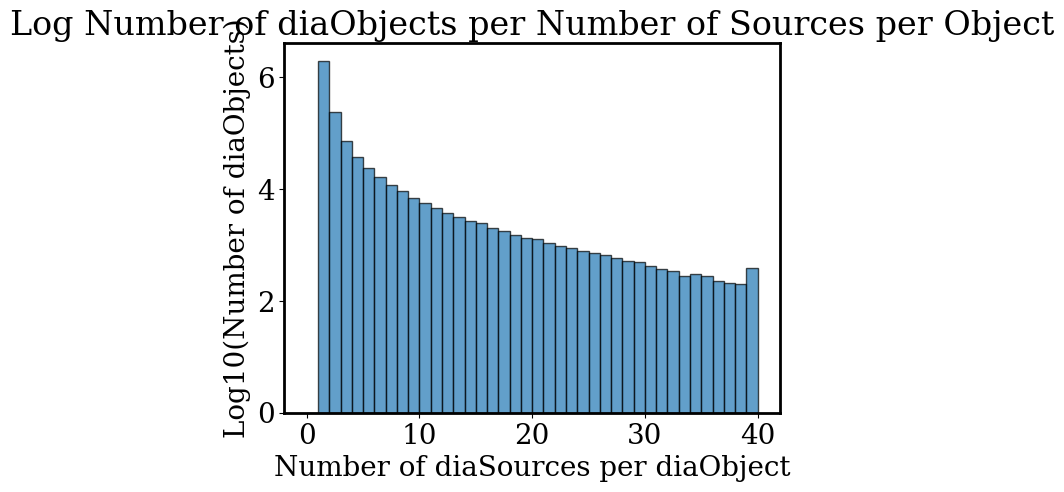

In [52]:
# List of tract indices to process
tract_indices = np.arange(0, len(obj_refs))

# Initialize lists to hold diaObj and diaSource DataFrames
dia_Obj_list = []
diaSource_list = []

# Loop through the specified tracts and fetch the data
for idx in tract_indices:
    obj_ref = obj_refs[idx]  # Select the corresponding obj_ref
    diaObject_tract = butler.get(obj_ref)  # Fetch diaObj for this tract
    diaSource_tract = butler.get('diaSourceTable_tract', dataId=obj_ref.dataId)  # Fetch diaSource for this tract
    
    # Append the results to the lists
    dia_Obj_list.append(diaObject_tract)
    diaSource_list.append(diaSource_tract)

# Concatenate all diaObj and diaSource DataFrames
combined_dia_Obj = pd.concat(dia_Obj_list, ignore_index=False)
combined_diaSource = pd.concat(diaSource_list, ignore_index=False)

# Drop duplicates based on the 'ra' column, keeping the first occurrence
combined_dia_Obj = combined_dia_Obj.drop_duplicates(subset='ra', keep='first')
# Drop duplicates based on the 'ra' column, keeping the first occurrence
combined_diaSource = combined_diaSource.drop_duplicates(subset='ra', keep='first')

diaObject = combined_dia_Obj.copy()
diaSource = combined_diaSource.copy()

# Compute the histogram of nDiaSources
counts, bin_edges = np.histogram(combined_dia_Obj['nDiaSources'], bins=40, range=(0, 40))

# Take the logarithm (base 10) of the counts
log_counts = np.log10(counts + 1)  # Add 1 to avoid log(0)

# Plot the histogram
plt.bar(bin_edges[:-1], log_counts, width=np.diff(bin_edges), align='edge', edgecolor='black', alpha=0.7)
plt.xlabel('Number of diaSources per diaObject')
plt.ylabel('Log10(Number of diaObjects)')
plt.title('Log Number of diaObjects per Number of Sources per Object')

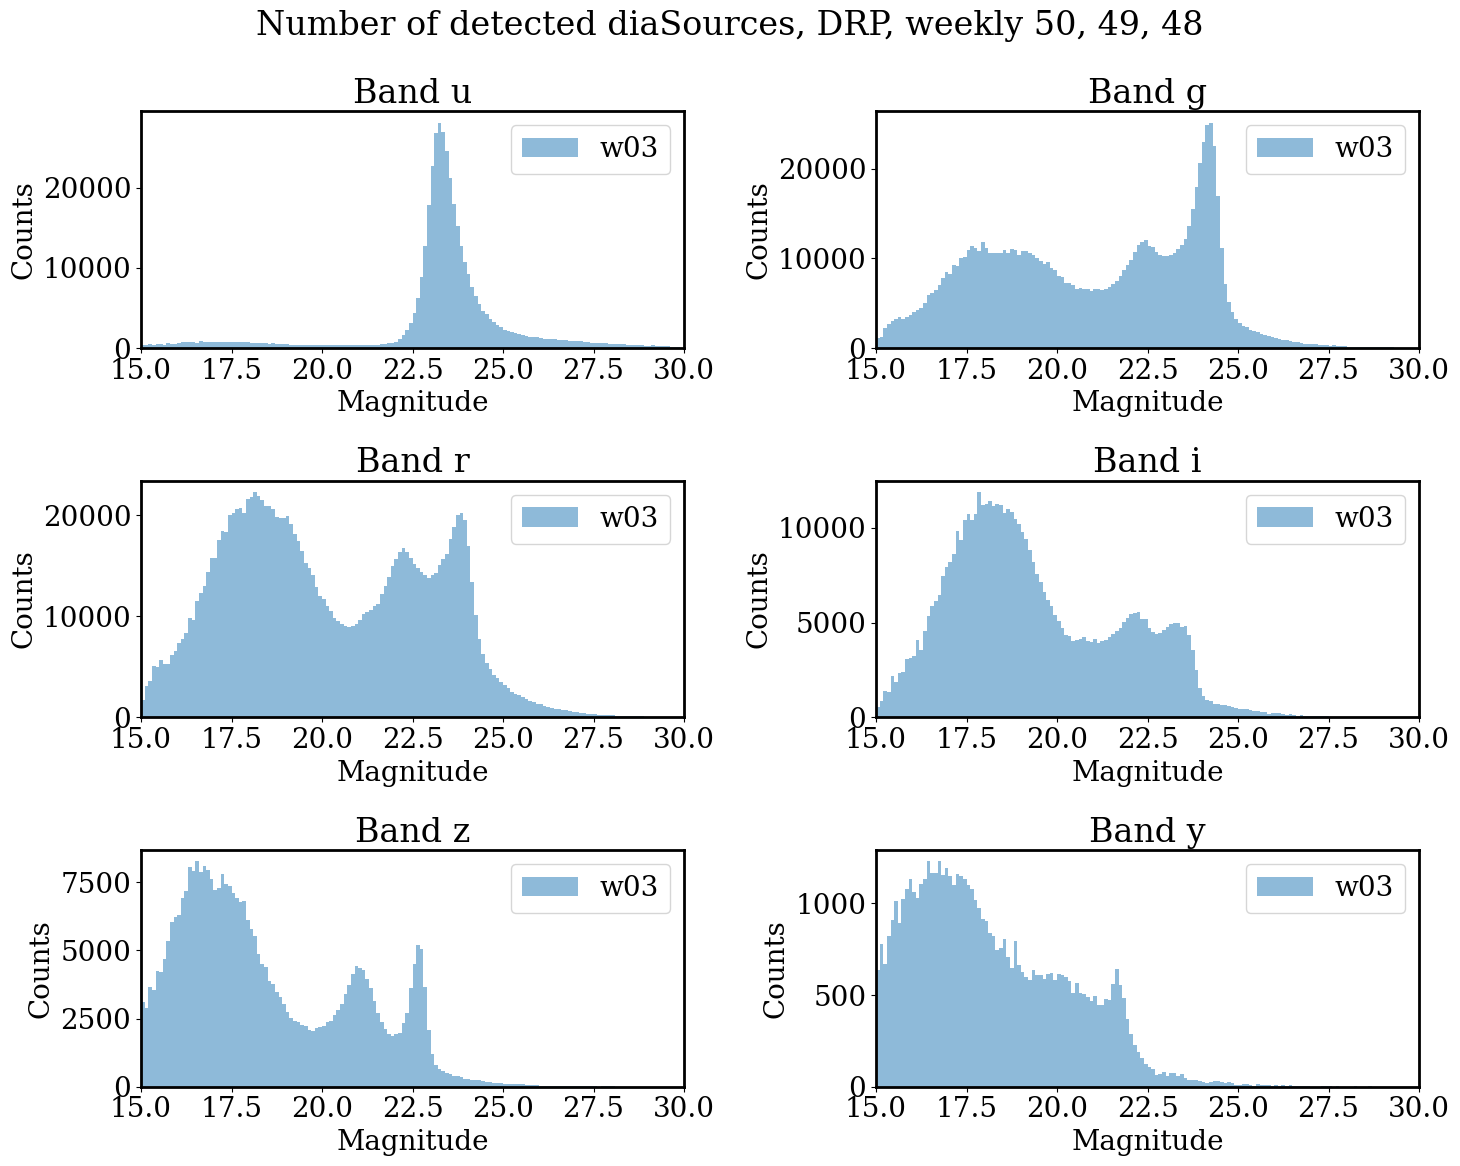

In [53]:
# Define the bands
bands = ['u', 'g', 'r', 'i', 'z', 'y']

# Create a figure with 6 subplots (3 rows, 2 columns)
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
plt.suptitle('Number of detected diaSources, DRP, weekly 50, 49, 48')
axes = axes.flatten()

# Loop over each band and create subplots
for idx, band in enumerate(bands):
    # Filter and process diaSource_50, diaSource_49, diaSource_48 for the current band
    dia_Source_single_band = diaSource[diaSource['band'] == band].copy()
    dia_Source_single_band.loc[:, 'scienceMag'] = create_mag(dia_Source_single_band['scienceFlux'].values)
    
    
    # Plot histograms
    ax = axes[idx]
    ax.hist(dia_Source_single_band['scienceMag'], alpha=0.5, label='w03', bins=np.arange(15, 30, 0.1))

    
    # Formatting
    ax.set_xlim(15, 30)
    ax.set_xlabel('Magnitude')
    ax.set_ylabel('Counts')
    ax.set_title(f'Band {band}')
    ax.legend()

# Adjust layout to avoid overlapping
plt.tight_layout()
plt.show()

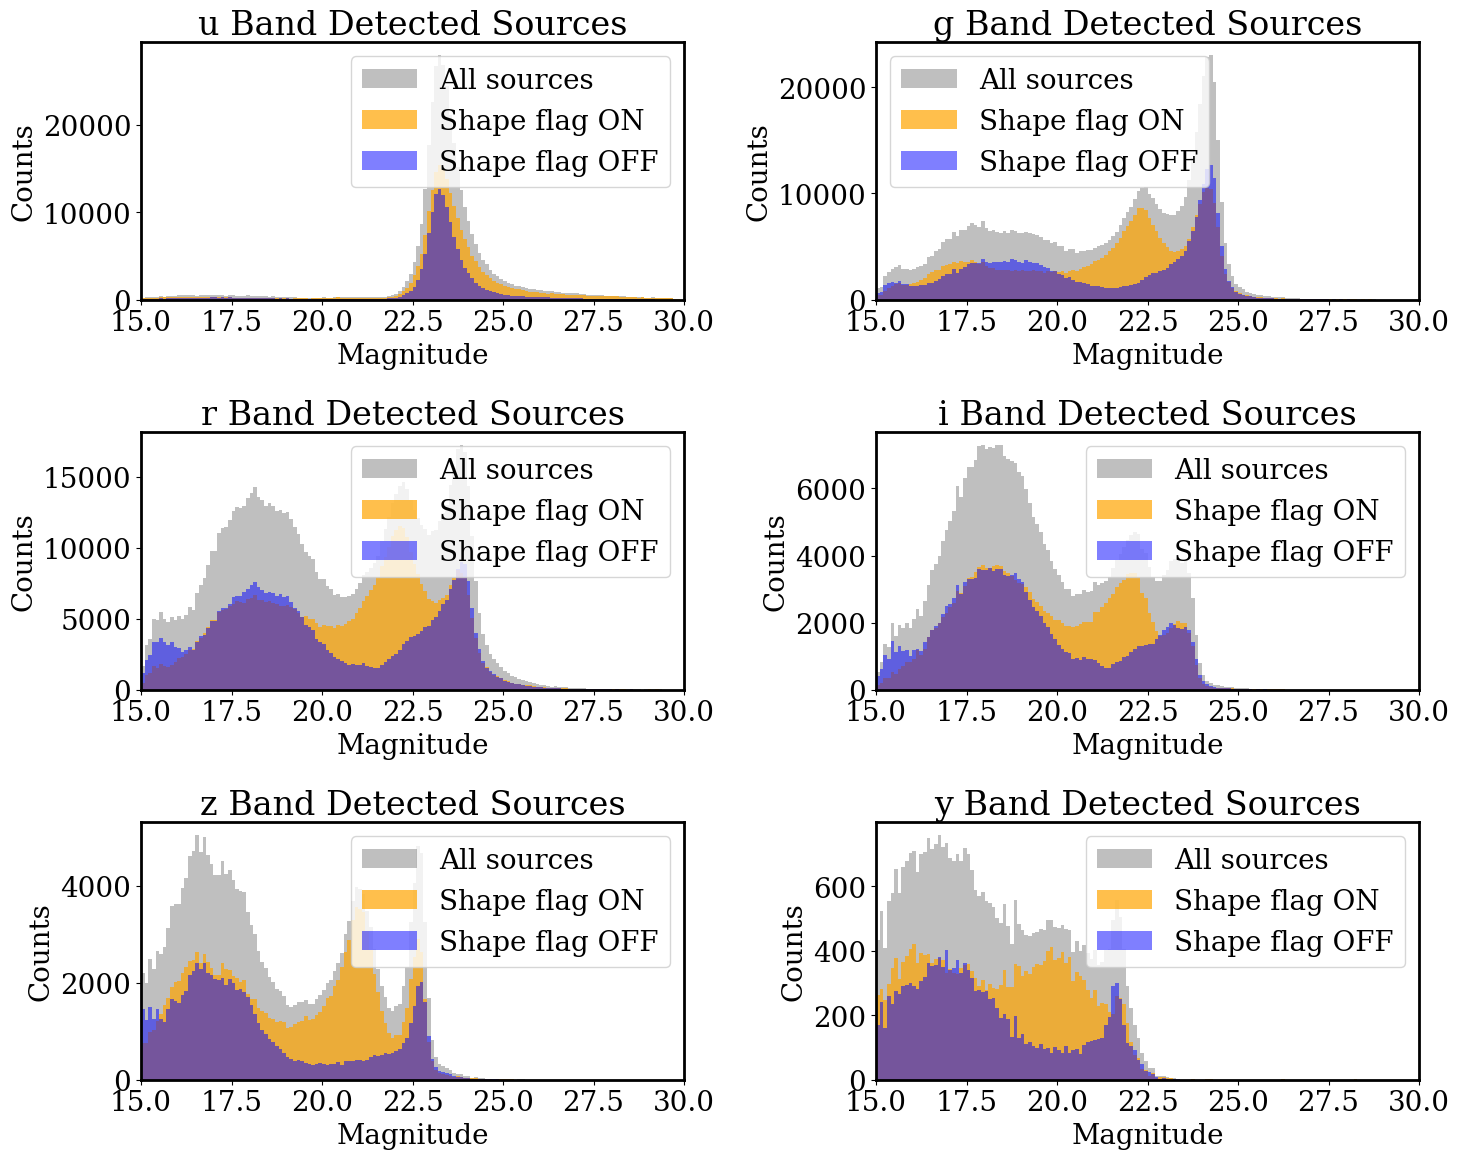

In [54]:

# List of bands to process
bands = ['u', 'g', 'r', 'i', 'z', 'y']

# Create a figure with 6 subplots (3 rows, 2 columns)
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
axes = axes.flatten()

# Process each band and plot
for idx, band in enumerate(bands):
    # Select sources for the current band
    dia_Source_single_band = diaSource[diaSource['band'] == band]
    dia_Source_single_band_positive = dia_Source_single_band[dia_Source_single_band['psfFlux'] > 0].copy()
    dia_Source_single_band_positive.loc[:, 'scienceMag'] = create_mag(dia_Source_single_band_positive['scienceFlux'].values)
    
    # Split based on shape_flag
    dia_Source_single_band_positive_shapeflag_positive = dia_Source_single_band_positive[dia_Source_single_band_positive['shape_flag'] == 1]
    dia_Source_single_band_positive_shapeflag_negative = dia_Source_single_band_positive[dia_Source_single_band_positive['shape_flag'] == 0]
    
    # Plot histograms
    ax = axes[idx]
    ax.hist(dia_Source_single_band_positive['scienceMag'], color='gray', alpha=0.5, bins=np.arange(15, 30, 0.1), label='All sources')
    ax.hist(dia_Source_single_band_positive_shapeflag_positive['scienceMag'], color='orange', alpha=0.7, bins=np.arange(15, 30, 0.1), label='Shape flag ON')
    ax.hist(dia_Source_single_band_positive_shapeflag_negative['scienceMag'], color='blue', alpha=0.5, bins=np.arange(15, 30, 0.1), label='Shape flag OFF')
    
    # Formatting
    ax.set_xlim(15, 30)
    ax.set_xlabel('Magnitude')
    ax.set_ylabel('Counts')
    ax.set_title(f'{band} Band Detected Sources')
    ax.legend()

# Adjust layout
plt.tight_layout()
plt.show()

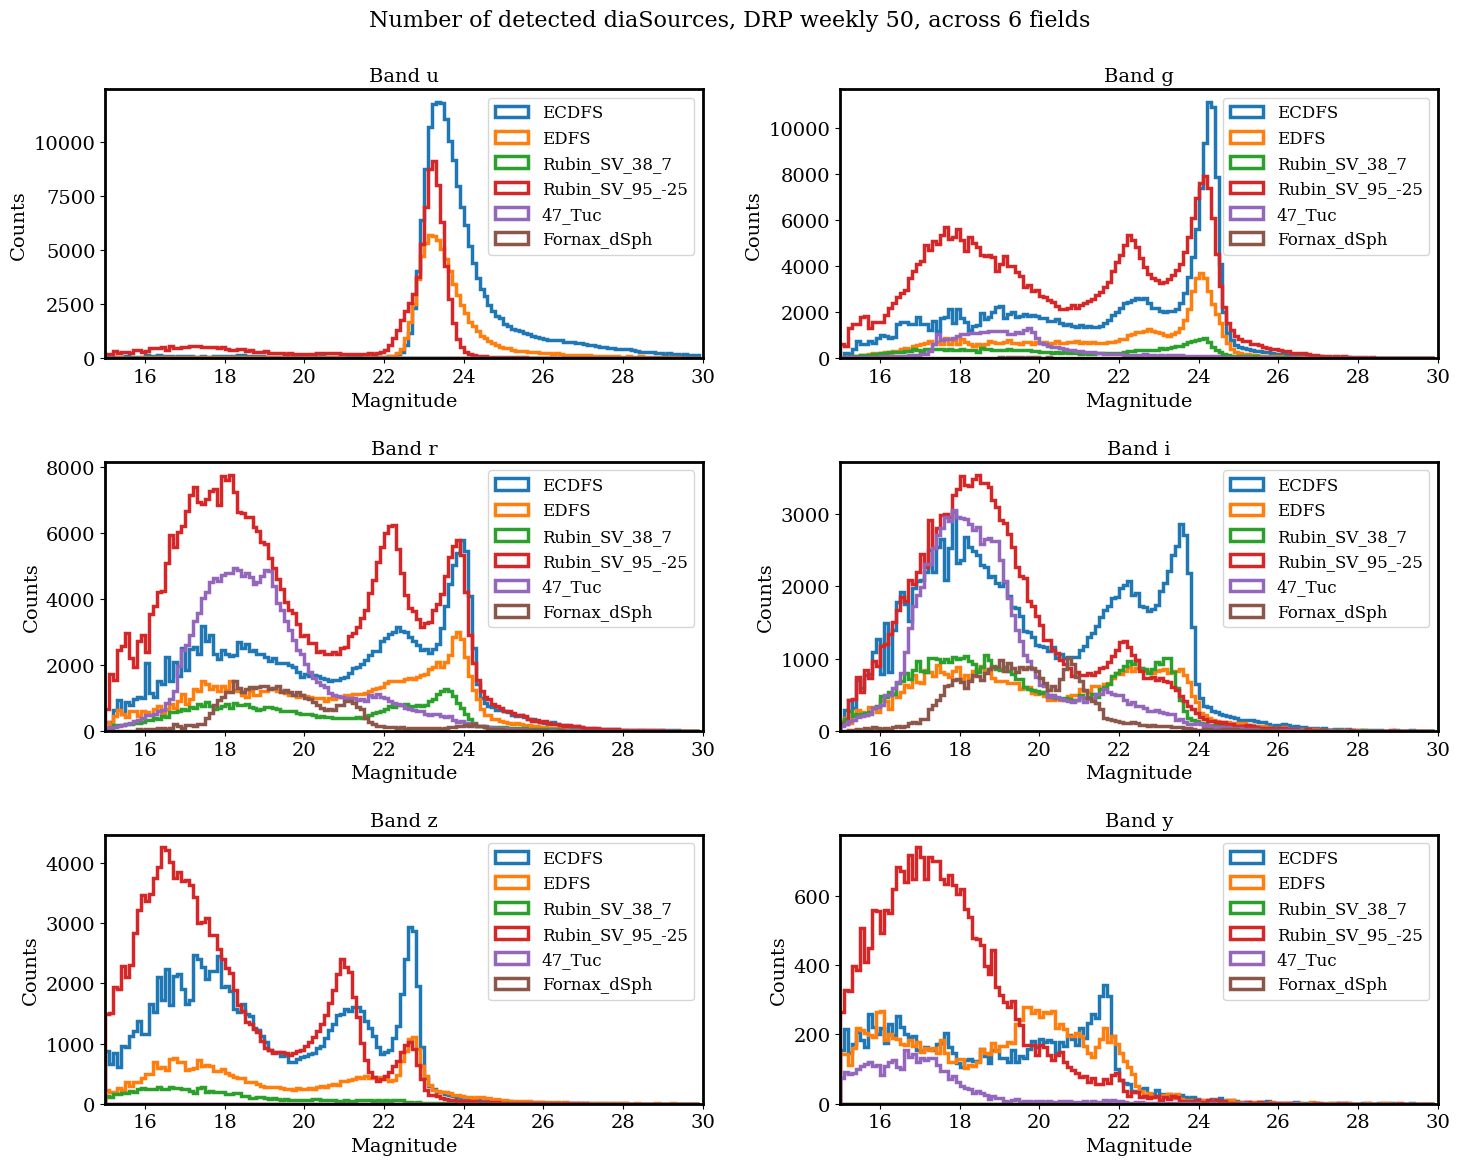

In [55]:
# Define the six fields with their coordinates
fields = {
    "ECDFS": (53.13, -28.10),  # Extended Chandra Deep Field South
    "EDFS": (59.10, -48.73),  # Euclid Deep Field South
    "Rubin_SV_38_7": (37.86, 6.98),  # Low Ecliptic Latitude Field
    "Rubin_SV_95_-25": (95.00, -25.00),  # Low Galactic Latitude Field
    "47_Tuc": (6.02, -72.08),  # 47 Tuc Globular Cluster
    "Fornax_dSph": (40.00, -34.45)  # Fornax Dwarf Spheroidal Galaxy
}

# Define the radius for selecting sources
selection_radius = 2.0  # 2-degree radius

# Create a figure with 6 subplots (3 rows, 2 columns)
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
plt.suptitle('Number of detected diaSources, DRP weekly 50, across 6 fields', fontsize=16)

axes = axes.flatten()

# Loop over each band and create subplots
for idx, band in enumerate(bands):
    # Prepare the plot for the current band
    ax = axes[idx]
    
    # Loop over each field to filter and process data
    for field_name, (ra_center, dec_center) in fields.items():
        # Filter data within the selection radius for the current field
        field_data = diaSource[
            (np.abs(diaSource['ra'] - ra_center) < selection_radius) &
            (np.abs(diaSource['dec'] - dec_center) < selection_radius)
        ].copy()

        # Filter data for the current band
        dia_Source_single_band = field_data[field_data['band'] == band].copy()
        dia_Source_single_band.loc[:, 'scienceMag'] = create_mag(dia_Source_single_band['scienceFlux'].values)
        
        # Plot the histogram as a line
        ax.hist(
            dia_Source_single_band['scienceMag'], 
            bins=np.arange(15, 30, 0.1), 
            histtype='step',  # Line histogram
            linewidth=2.5,    # Line thickness
            label=field_name
        )
    
    # Formatting for the current subplot
    ax.set_xlim(15, 30)
    ax.set_xlabel('Magnitude', fontsize=14)
    ax.set_ylabel('Counts', fontsize=14)
    ax.set_title(f'Band {band}', fontsize=14)
    ax.legend(fontsize=12)  # Increase legend font size
    ax.tick_params(axis='both', which='major', labelsize=14)  # Increase tick label size

# Adjust layout to avoid overlapping
plt.tight_layout()
plt.show()

In [66]:
# only take Rubin_SV_95_-25
band = 'r'
dia_Source_single_band = diaSource[diaSource['band'] == band].copy()
dia_Source_single_band.loc[:, 'scienceMag'] = create_mag(dia_Source_single_band['scienceFlux'].values)
ra_center, dec_center = 95.00, -25.00
dia_Source_singleF_singleB = dia_Source_single_band[
    (np.abs(dia_Source_single_band['ra'] - ra_center) < selection_radius) &
    (np.abs(dia_Source_single_band['dec'] - dec_center) < selection_radius)
].copy()

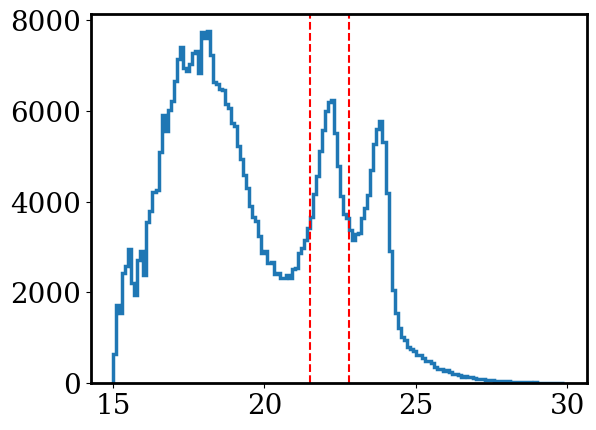

In [70]:
# Plot the histogram as a line
plt.hist(
    dia_Source_singleF_singleB['scienceMag'], 
    bins=np.arange(15, 30, 0.1), 
    histtype='step',  # Line histogram
    linewidth=2.5,    # Line thickness
    label=field_name
);

plt.axvline(22.8, color='red', linestyle='--', label='22.5 mag')
plt.axvline(21.5, color='red', linestyle='--', label='22.5 mag')

In [131]:
dia_Source_interest = dia_Source_singleF_singleB[(dia_Source_singleF_singleB['scienceMag'] < 22.8) & (dia_Source_singleF_singleB['scienceMag'] > 21.5)]

# Load the Parquet file into a DataFrame
summary_stats = pd.read_parquet("summary_stats.parquet")

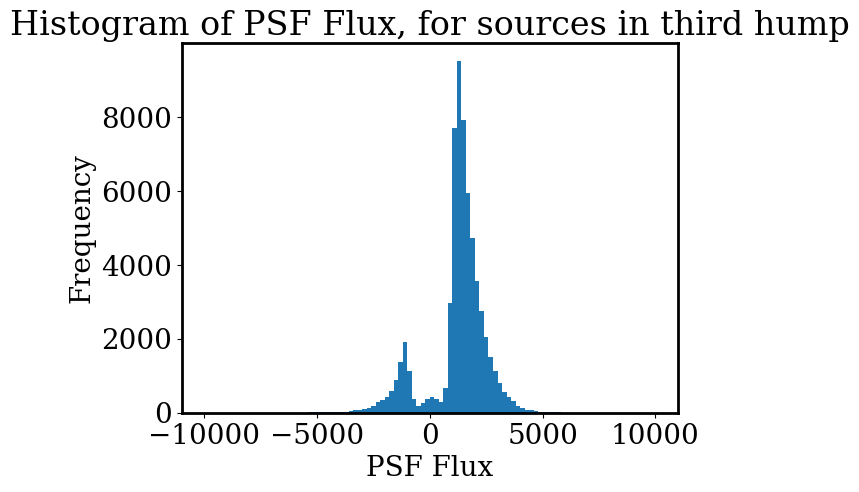

In [132]:

# Define bins from -10000 to 10000 with 100 bins
bins = np.linspace(-10000, 10000, 101)  # 101 edges create 100 bins

# Plot the histogram with the specified bins
plt.hist(dia_Source_interest['psfFlux'], bins=bins)

# Labels and title for better readability
plt.xlabel('PSF Flux')
plt.ylabel('Frequency')
plt.title('Histogram of PSF Flux, for sources in third hump')

# Show the plot
plt.show()

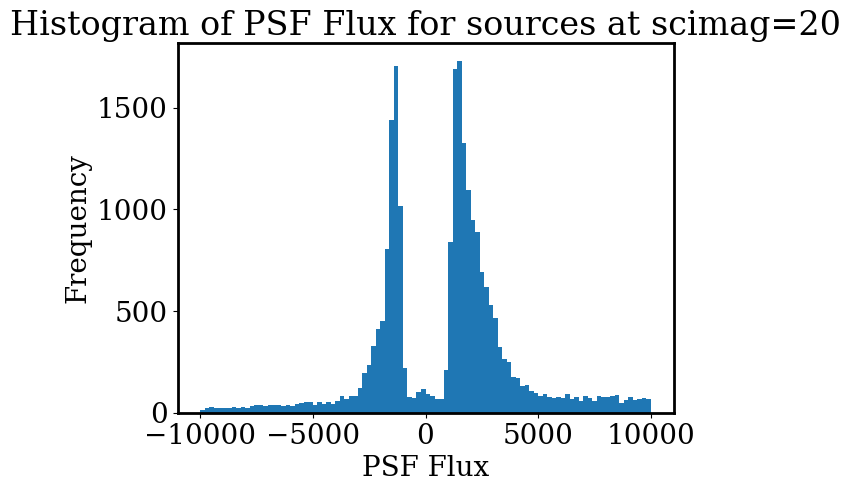

In [133]:
dia_Source_interest = dia_Source_singleF_singleB[(dia_Source_singleF_singleB['scienceMag'] < 20.4) & (dia_Source_singleF_singleB['scienceMag'] > 19.56)]

# Define bins from -10000 to 10000 with 100 bins
bins = np.linspace(-10000, 10000, 101)  # 101 edges create 100 bins

# Plot the histogram with the specified bins
plt.hist(dia_Source_interest['psfFlux'], bins=bins)

# Labels and title for better readability
plt.xlabel('PSF Flux')
plt.ylabel('Frequency')
plt.title('Histogram of PSF Flux for sources at scimag=20')

# Show the plot
plt.show()


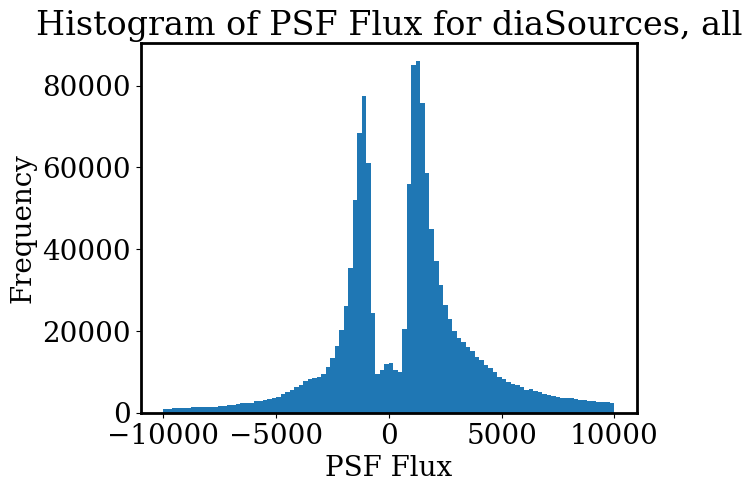

In [135]:
dia_Source_interest 

# Define bins from -10000 to 10000 with 100 bins
bins = np.linspace(-10000, 10000, 101)  # 101 edges create 100 bins

# Plot the histogram with the specified bins
plt.hist(dia_Source_single_band['psfFlux'], bins=bins)

# Labels and title for better readability
plt.xlabel('PSF Flux')
plt.ylabel('Frequency')
plt.title('Histogram of PSF Flux for diaSources, all')

# Show the plot
plt.show()


In [101]:
visit_nm_interest = np.unique(dia_Source_interest['visit'], return_counts=True)
visit_detector_counts = dia_Source_interest.groupby(['visit', 'detector']).size()


dia_Source_interest_with_meta = dia_Source_interest.merge(
    summary_stats[['magLim','psfSigma', 'visit', 'detector']],
    on=['visit', 'detector'],
    how='left'
)

In [142]:
list_of_pos_frac = []
for i in np.arange(15,25,0.5):
    dia_Source_singleF_singleB_single_mag = dia_Source_singleF_singleB[(dia_Source_singleF_singleB['scienceMag']>i) & (dia_Source_singleF_singleB['scienceMag']<i+0.5)] 
    list_of_pos_frac.append([np.median(dia_Source_singleF_singleB_single_mag['scienceMag']), np.sum(dia_Source_singleF_singleB_single_mag['psfFlux']>0)/len(dia_Source_singleF_singleB_single_mag)])
    
array_of_pos_frac = np.array(list_of_pos_frac)

Text(0, 0.5, 'Fraction of positive psfFlux sources')

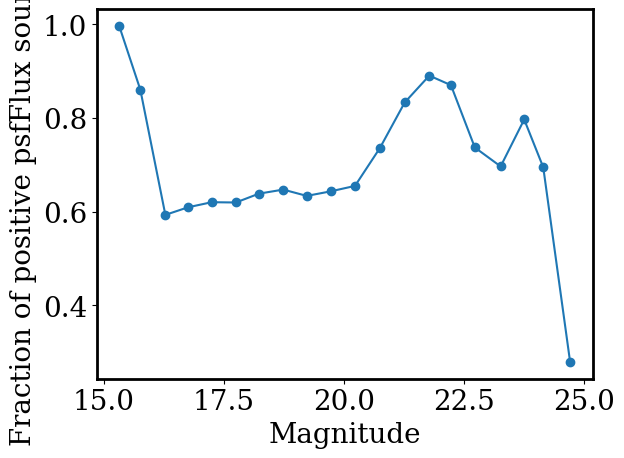

In [144]:
plt.plot(array_of_pos_frac[:,0], array_of_pos_frac[:,1], 'o-')
plt.xlabel('Magnitude')
plt.ylabel('Fraction of positive psfFlux sources')

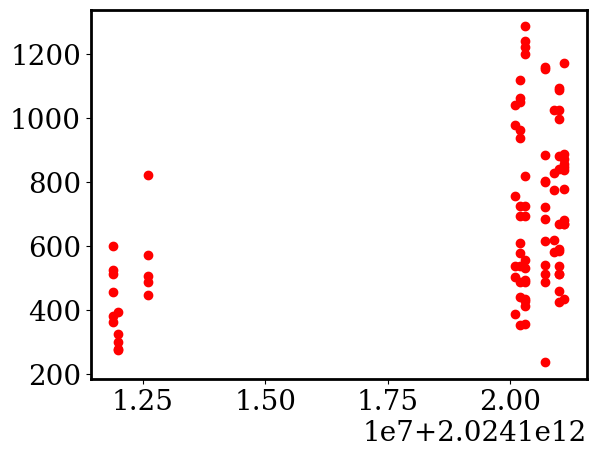

In [81]:
plt.scatter(visit_nm_interest[0], visit_nm_interest[1], color='red', label='Interesting sources')

In [106]:
unique_sources_per_visit_detector = dia_Source_interest.groupby(['visit', 'detector'])['diaObjectId'].nunique().reset_index()
unique_sources_per_visit_detector.rename(columns={'diaObjectId': 'num_unique_sources'}, inplace=True)

# Step 2: Merge metadata from summary_stats
dia_Source_interest_with_meta = dia_Source_interest.merge(
    summary_stats[['magLim', 'psfSigma', 'visit', 'detector']],
    on=['visit', 'detector'],
    how='left'
)

# Step 3: Aggregate to ensure one row per visit and per detector
result = dia_Source_interest_with_meta.groupby(['visit', 'detector']).agg(
    num_unique_sources=('diaObjectId', 'nunique'),  # Count unique sources per visit and detector
    magLim=('magLim', 'first'),  # First occurrence
    psfSigma=('psfSigma', 'first'),  # First occurrence
    median_coord_ra=('coord_ra', 'median'),  # Median RA per visit and detector
    median_coord_dec=('coord_dec', 'median')  # Median Dec per visit and detector
).reset_index()

result

,visit,detector,num_unique_sources,magLim,psfSigma,median_coord_ra,median_coord_dec
0,2024111900373,0,44,23.972903,1.893090,94.764424,-24.980742
1,2024111900373,1,30,23.990832,1.864461,94.775900,-24.742648
2,2024111900373,2,26,23.974838,1.860541,94.921393,-24.518943
3,2024111900373,3,63,23.921184,2.008468,94.997263,-25.030976
4,2024111900373,4,53,23.963383,1.921999,95.072483,-24.830065
...,...,...,...,...,...,...,...
823,2024121100587,4,103,24.640889,1.652352,95.094420,-24.890969
824,2024121100587,5,74,24.633438,1.662771,95.286357,-24.739667
825,2024121100587,6,72,24.626490,1.680955,95.070037,-25.203946
826,2024121100587,7,72,24.646098,1.651355,95.280084,-25.049522


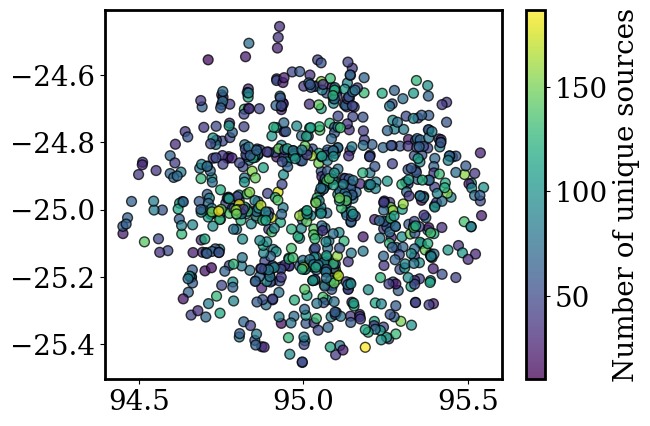

In [109]:
plt.scatter(result['median_coord_ra'], result['median_coord_dec'], label='Interesting sources', c=result['num_unique_sources'],  # Color based on num_unique_sources
    cmap='viridis',  # Colormap for better visibility
    edgecolor='black',  # Make markers more visible
    s=50,  # Adjust marker size
    alpha=0.75)

plt.colorbar(label='Number of unique sources')

In [112]:
result[result['num_unique_sources']>170]

,visit,detector,num_unique_sources,magLim,psfSigma,median_coord_ra,median_coord_dec
345,2024120300070,3,179,23.972541,2.991902,94.923372,-24.947713
350,2024120300070,8,187,23.996717,2.961087,95.188500,-25.409709
355,2024120300071,4,176,23.824190,3.418092,94.902690,-25.023714
550,2024120700529,1,185,24.036249,2.985845,94.805310,-24.984287
721,2024121000522,1,184,24.221717,2.565102,94.743030,-25.004846
763,2024121100570,7,171,24.560451,1.840024,95.107051,-25.196690


In [123]:
result[result['num_unique_sources']<20]

,visit,detector,num_unique_sources,magLim,psfSigma,median_coord_ra,median_coord_dec
29,2024111900376,2,16,23.920527,1.944482,94.710870,-24.554046
60,2024112000304,6,10,23.282446,4.629359,95.136944,-25.235308
93,2024112000308,3,19,23.395516,4.155680,94.701142,-25.182258
96,2024112000308,6,18,23.353673,4.493431,94.933227,-25.338452
270,2024120200359,0,18,24.300661,2.447917,94.720818,-25.172997
497,2024120700523,2,13,24.235310,2.520091,94.941246,-24.767737
503,2024120700523,8,15,24.262301,2.459241,95.359389,-24.972276


In [121]:
result[(result['median_coord_ra']>94.90) & (result['median_coord_ra']<94.94 ) & (result['median_coord_dec']>-25.0) & (result['median_coord_dec']<-24.90)]

,visit,detector,num_unique_sources,magLim,psfSigma,median_coord_ra,median_coord_dec
40,2024111900377,4,85,23.750393,2.300751,94.938705,-24.994116
345,2024120300070,3,179,23.972541,2.991902,94.923372,-24.947713
478,2024120700461,1,119,24.252846,2.551673,94.915193,-24.963875
490,2024120700462,4,141,24.216382,2.560317,94.922772,-24.971536
613,2024121000500,1,48,24.376835,2.139479,94.935335,-24.924768


In [124]:
2024121000500, 1

(2024121000500, 1)

In [ ]:
2024120300070, 3

In [59]:
dia_Source_singleF_singleB[(dia_Source_singleF_singleB['scienceMag'] < 23) & (dia_Source_singleF_singleB['scienceMag'] > 22)][15000:]

,visit,detector,band,diaObjectId,ssObjectId,parentDiaSourceId,midpointMjdTai,bboxSize,time_processed,ra,...,trail_flag_edge,pixelFlags_streak,pixelFlags_streakCenter,pixelFlags_injected,pixelFlags_injectedCenter,pixelFlags_injected_template,pixelFlags_injected_templateCenter,coord_ra,coord_dec,scienceMag
diaSourceId,,,,,,,,,,,,,,,,,,,,,
191684640627490854,2024120100169,6,r,2226801317316144339,0,0,60646.077219,44,2025-01-19 04:53:44.005805,52.772805,...,False,False,False,False,False,False,False,52.772829,-28.125660,22.642381
191684640627490855,2024120100169,6,r,2226801317316145343,0,0,60646.077219,28,2025-01-19 04:53:44.005805,52.773458,...,False,False,False,False,False,False,False,52.773470,-28.128046,22.975259
191684640627490875,2024120100169,6,r,2226801317316147208,0,0,60646.077219,58,2025-01-19 04:53:44.005805,52.710714,...,False,False,False,False,False,False,False,52.710765,-28.097842,22.926312
191684640627490877,2024120100169,6,r,2226801317316145894,0,0,60646.077219,75,2025-01-19 04:53:44.005805,52.710474,...,False,False,False,False,False,False,False,52.710420,-28.101124,22.097317
191684640627490887,2024120100169,6,r,2226801317316147336,0,0,60646.077219,18,2025-01-19 04:53:44.005805,52.725918,...,False,False,False,False,False,False,False,52.725873,-28.132691,22.838571
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191860485186912311,2024120600097,8,r,2132999781327318144,0,0,60651.103707,94,2025-01-19 05:15:20.175461,53.145934,...,False,False,False,False,False,False,False,53.146023,-28.402710,22.531153
190875482747568181,2024110800246,6,r,2133034965699395654,0,0,60623.259329,37,2025-01-19 04:53:18.311550,53.518339,...,False,False,False,False,False,False,False,53.518363,-28.184308,22.683564
190875482747568184,2024110800246,6,r,2133034965699395656,0,0,60623.259329,70,2025-01-19 04:53:18.311550,53.520718,...,False,False,False,False,False,False,False,53.520773,-28.184718,22.864897


In [60]:
ra_target, dec_target = dia_Source_singleF_singleB.loc[191684640627490875]['ra'], dia_Source_singleF_singleB.loc[191684640627490875]['dec']
ra_target, dec_target

(np.float64(52.71071403621872), np.float64(-28.097857666163023))

In [61]:
dia_Source_singleF_singleB_small_cut = dia_Source_singleF_singleB[(dia_Source_singleF_singleB['ra'] < (ra_target+0.003)) & (dia_Source_singleF_singleB['ra'] > (ra_target-0.003)) & (dia_Source_singleF_singleB['dec'] < (dec_target+0.003)) & (dia_Source_singleF_singleB['dec'] > (dec_target-0.003))]

In [62]:
visit_ids = np.unique(dia_Source_singleF_singleB_small_cut['visit'])
len(visit_ids)

68

In [63]:
dia_Source_singleF_singleB_small_cut_single_visit=dia_Source_singleF_singleB_small_cut[dia_Source_singleF_singleB_small_cut['visit'] == visit_ids[52]]
dia_Source_singleF_singleB_small_cut_single_visit

,visit,detector,band,diaObjectId,ssObjectId,parentDiaSourceId,midpointMjdTai,bboxSize,time_processed,ra,...,trail_flag_edge,pixelFlags_streak,pixelFlags_streakCenter,pixelFlags_injected,pixelFlags_injectedCenter,pixelFlags_injected_template,pixelFlags_injected_templateCenter,coord_ra,coord_dec,scienceMag
diaSourceId,,,,,,,,,,,,,,,,,,,,,
191825315813654536,2024120500111,0,r,2226805715362649885,0,0,60650.229069,16,2025-01-19 05:23:00.884941,52.707727,...,False,False,False,False,False,False,False,52.707759,-28.099012,22.888108


In [64]:
ra_target, dec_target 

(np.float64(52.71071403621872), np.float64(-28.097857666163023))

NameError: name 'ra_single' is not defined

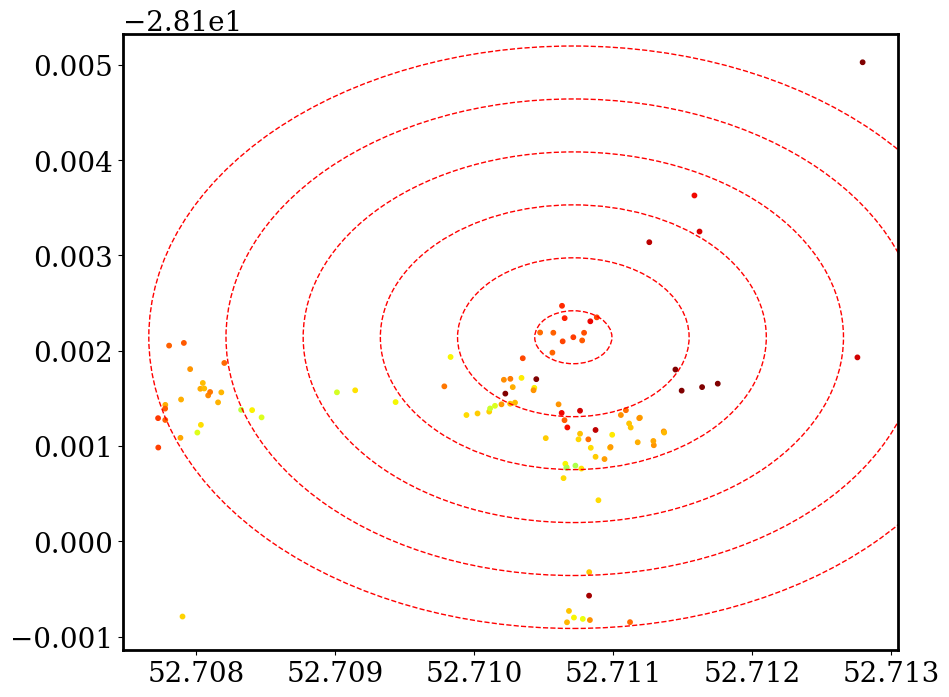

In [65]:
# Define radii in arcseconds and convert to degrees
radii_arcseconds = [1, 3, 5, 7, 9, 11]
radii_degrees = [r / 3600 for r in radii_arcseconds]

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 8))

# Scatter plot with color map
sc = ax.scatter(
    dia_Source_singleF_singleB_small_cut['ra'],  # RA
    dia_Source_singleF_singleB_small_cut['dec'],  # Dec
    s=10,  # Marker size
    c=dia_Source_singleF_singleB_small_cut['scienceMag'],  # Color based on scienceMag
    cmap='jet',  # Color map
    vmin=17,  # Min value for color scale
    vmax=24,  # Max value for color scale
)

# Add concentric circles
for radius, radius_arcsec in zip(radii_degrees, radii_arcseconds):
    circle = plt.Circle(
        (ra_target, dec_target),  # Center of the circle
        radius,  # Radius in degrees
        color='red',  # Circle color
        fill=False,  # Don't fill the circle
        linestyle='--',  # Dashed line
        linewidth=1,  # Line width
        label=f"Radius {radius_arcsec} arcsec",  # Label for legend
    )
    ax.add_artist(circle)

# Set axis limits
ax.set_xlim(ra_single - 0.003, ra_single + 0.003)
ax.set_ylim(dec_single - 0.003, dec_single + 0.003)

# Add colorbar
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label('Science Mag')

# Add legend
ax.legend(loc='upper right')

# Add labels and title
ax.set_xlabel("Right Ascension (degrees)")
ax.set_ylabel("Declination (degrees)")
ax.set_title("Scatter Plot with Concentric Circles")

# Show the plot
plt.show()

In [189]:
len(visit_ids)

68

In [1]:
import lsst.daf.butler as dafButler

config = '/repo/main'
collections = 'LSSTComCam/runs/DRP/DP1/w_2025_03/DM-48478'
butler = dafButler.Butler(config, collections=collections)

refs = butler.query_datasets("diaObjectTable_tract")
unique_lens = {len(butler.get("diaObjectTable_tract", dataId=ref.dataId).columns) for ref in refs}
## We would expect this to have a single element, of 136
## instead result is `{26, 70, 92, 114, 136}`
unique_lens

INFO:numexpr.utils:Note: detected 128 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:numexpr.utils:Note: NumExpr detected 128 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


{26, 70, 92, 114, 136}

In [9]:
ref = refs[11]
butler.get("diaObjectTable_tract", dataId=ref.dataId)[['r_psfFluxMean','i_psfFluxMean', 'g_psfFluxMean']]

,r_psfFluxMean,i_psfFluxMean,g_psfFluxMean
diaObjectId,,,
1855113610569711617,-796.218813,NaN,NaN
1855113610569711618,-839.923888,NaN,NaN
1855113610569711619,-932.797237,NaN,NaN
1855113610569711620,-850.945744,NaN,NaN
1855113610569711621,-801.017185,NaN,NaN
...,...,...,...
1855219163685978123,NaN,1903.401802,NaN
1855223561732489217,-8789.622772,-8941.745751,NaN
1855223561732489218,NaN,NaN,8243.049099
